# Airbus Quantum Computing Challenge - Aircraft Loading Optimisation

Aircraft Loading Optimization is about making the best choices on which parts of the available payload to take
on board, and where to place them on the aircraft. An airline tries to make best use of the aircraft’s payload
capabilities in order to maximise revenue, and to optimise parameters with performance impact towards lower
operating costs (fuel burn). The space for optimization is limited by the operational envelope of the aircraft,
which must be respected at all times. The most notable limits here are the maximum payload capacity of the
aircraft on a specific mission, the centre of gravity position of the loaded aircraft and its fuselage shear limits.
This problem statement describes a simplified representation of this class of problems, with stepwise
implementation of the constraints and the associated optimization target. The overall objective is the practical
demonstration of problem solving by use of quantum computing, and the robust assessment of scalability
towards more complex problems.

A freighter aircraft has 𝑁 positions for standard size cargo containers equally distributed along the fuselage
main deck. A set of 𝑛 cargo containers of up to three different sizes is available for loading. Standard size containers (1)
occupy a single position, half size containers (2) may share a single position, whereas double size containers
(3) occupy two adjacent positions. Each container in this set has an individual mass mi , which lies in between
the empty mass and the maximum mass of each container type. Typically, the combined maximum masses
of all containers exceed the aircraft’s payload capacity. 

In [1]:
import sympy as sym
import numpy as np

In [4]:
n=35
N=20
W=40000
m=[2134.0, 3455.0, 1866.0, 1699.0, 3500.0, 3332.0, 2578.0, 2315.0, 1888.0, 1786.0, 
   3277.0, 2987.0, 2534.0, 2111.0, 2607.0, 1566.0, 1765.0, 1946.0, 1732.0, 1641.0, 
   1800.0, 986.0, 873.0, 1764.0, 1239.0, 1487.0, 769.0, 836.0, 659.0, 765.0, 3132.0, 
   3530.0, 3892.0, 3464.0, 3282.0] 
t=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
   1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
   1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
   0.5, 0.5, 0.5, 0.5, 0.5]
d=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
   1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
   0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
   1.0, 1.0, 1.0, 1.0, 1.0]
 
K = n + N + (len(bin(W))-2) # number of slack variables: K = n + N + number of bits of binary expansion of W

# len(z) equals the number of qubits in QAOA circuit
z=[sym.Symbol(f'z_{i}') for i in range(n*N+K)]

# Load results obtained from Mathematica notebook airbus.nb
def read_quadratic(path):
    lines=[]
    with open(path) as f:
        for line in f:
            cols = line.strip().split(',')
            lines.append(np.array([float(x) for x in cols]))
    quadratic = np.stack(lines)
    return quadratic

def read_linear(path):
    lst = []
    with open(path) as f:
        for line in f:
            lst.append(float(line.strip()))
    linear = np.array(lst)
    return linear

quadratic = read_quadratic('airbus-data/quadratic.csv')
linear = read_linear('airbus-data/linear.csv')

def f_obj():
    """ objective fucntion """
    exp = 0 # init a expression
    for i in range(n):
        for j in range(N):
            exp = exp - t[i] * m[i] * z[i*N+j]

    return exp

payload = f_obj()
qubo = None

## Generate QUBO

In [5]:
import copy
def mix_linear_quadratic(linear, quadratic, dict_=True):
    """
    for bianry variable z_i, z_i = z_i^2
    """
    quadratic = copy.deepcopy(quadratic)
    for i in range(len(z)):
        quadratic[i,i] += linear[i]
    
    quadratic_dict = {}
    for i in range(len(z)):
        for j in range(len(z)):
            if j >= i:
                quadratic_dict[(i, j)] = quadratic[i, j]

    if dict_:
        return quadratic_dict
    else:
        return quadratic

In [6]:
Q = mix_linear_quadratic(linear, quadratic)
print(len(Q))

297606


## Sample on Dynex

In [7]:
import dynex

In [8]:
sampleset = dynex.sample_qubo(Q, 0.0, mainnet=False, num_reads=50000, annealing_time = 1000);
print('Result:')
print(sampleset)

[ÐYNEX] PRECISION CUT FROM 100000.0 TO 1
[DYNEX] PRECISION SET TO 1
[DYNEX] SAMPLER INITIALISED
[DYNEX|TESTNET] *** WAITING FOR READS ***
[DYNEX] Keyboard interrupt
Result:
{'error': 'Keyboard interrupt'}


In [14]:
results = list(sampleset.samples())

In [15]:
payload = f_obj()
for i, result in enumerate(results):
      replacements = []
      for key, val in result.items():
          replacements.append((z[key], val))
      print(f'{i}: {payload.subs(replacements)}')

0: -39504.0000000000


In [16]:
if qubo is not None:
    print('optimal function value:', qubo.subs(replacements))
else:
    print('optimal function value:', payload.subs(replacements))
    
optimal_values = [j for i, j in replacements]
array = np.zeros((35,20))
for i in range(n):
    for j in range(N):
        array[i,j] = optimal_values[i*N+j] 

print('optimal value:', optimal_values)
print('status: SUCCESS')

optimal function value: -39504.0000000000
optimal value: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

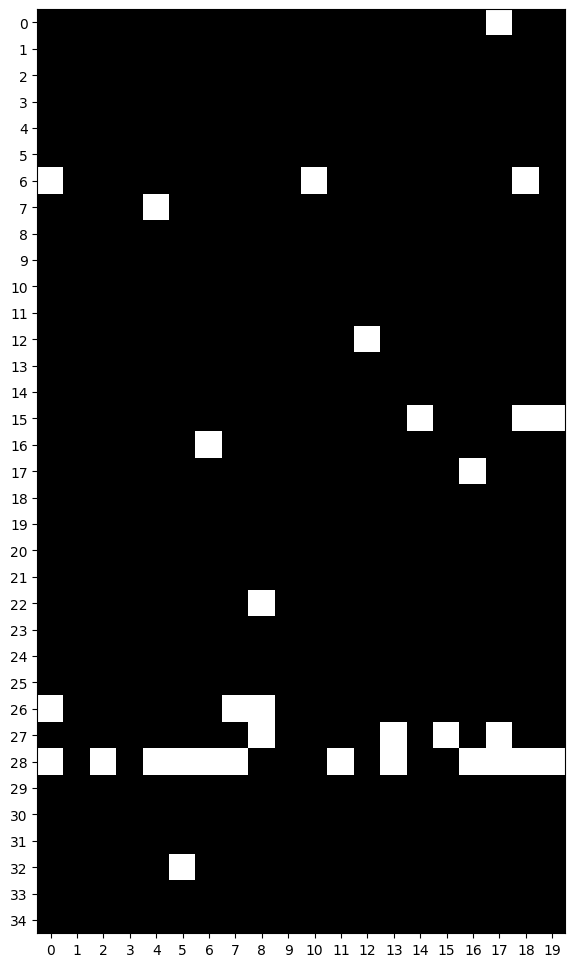

In [18]:
plt.figure(figsize=(12, 12))
plt.imshow(array, cmap='gray', vmin=0, vmax=1.)
plt.xticks(np.arange(0, 20, 1))
plt.yticks(np.arange(0, 35, 1))
plt.show()